# Mesh refinement

In this tutorial, we use the estimator obtained by the equilibrated flux to
drive an adative mesh refinement (AMR) procedure.  We consider the Laplace
problem

$$
\begin{align}
-\Delta u &= 0 &&\text{ in }\Omega\\
u &= g &&\text{ on }\partial\Omega
\end{align}
$$

on an L-shaped domain $\Omega = (-1,1)^2 \setminus [(0,1)\times(-1,0)]$.  We
load this domain from a json file.

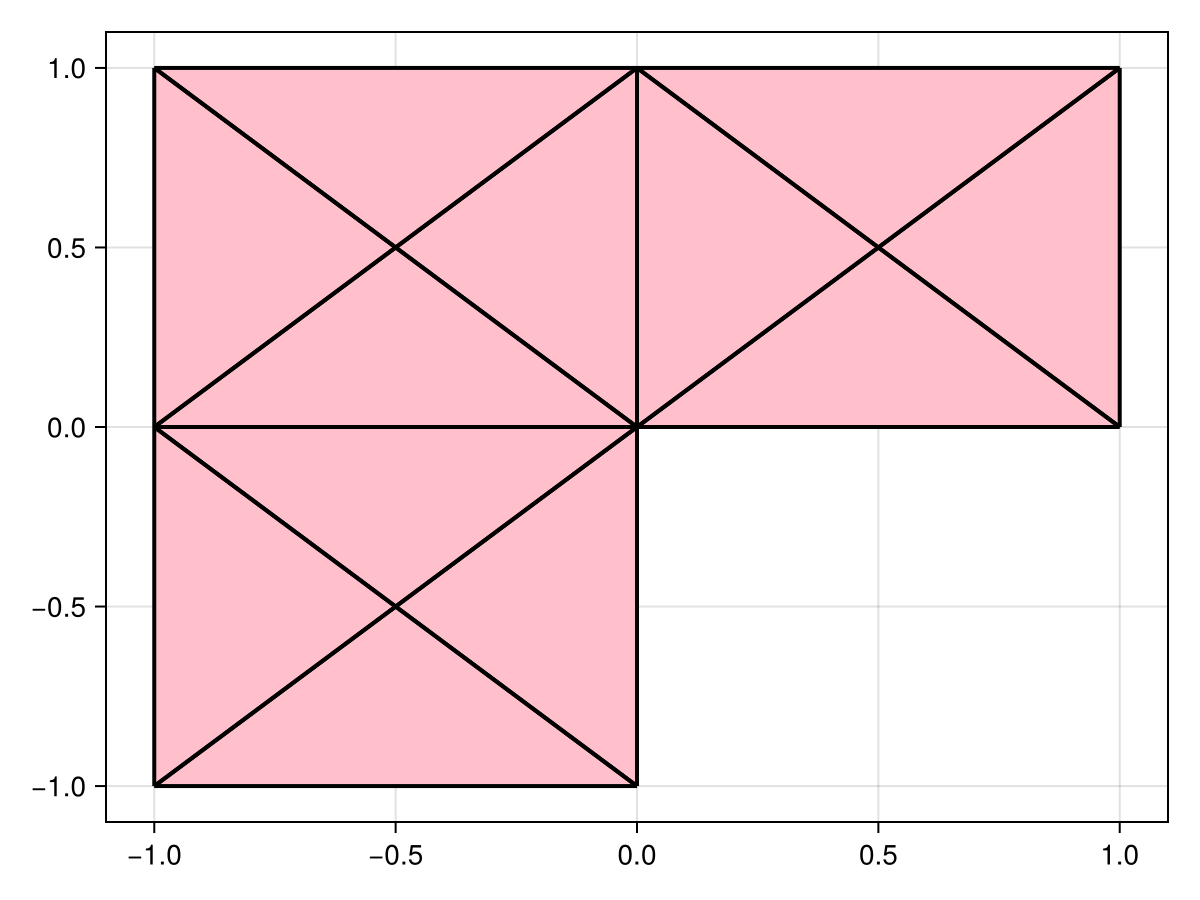

In [1]:
using Gridap, GridapMakie, CairoMakie

model = DiscreteModelFromFile("Lshaped.json")
Ω = Triangulation(model)

fig = plot(Ω)
wireframe!(Ω, color=:black, linewidth=2);
fig

In this case, we know the true solution $u$ is given by the following formula
in polar coordinates:

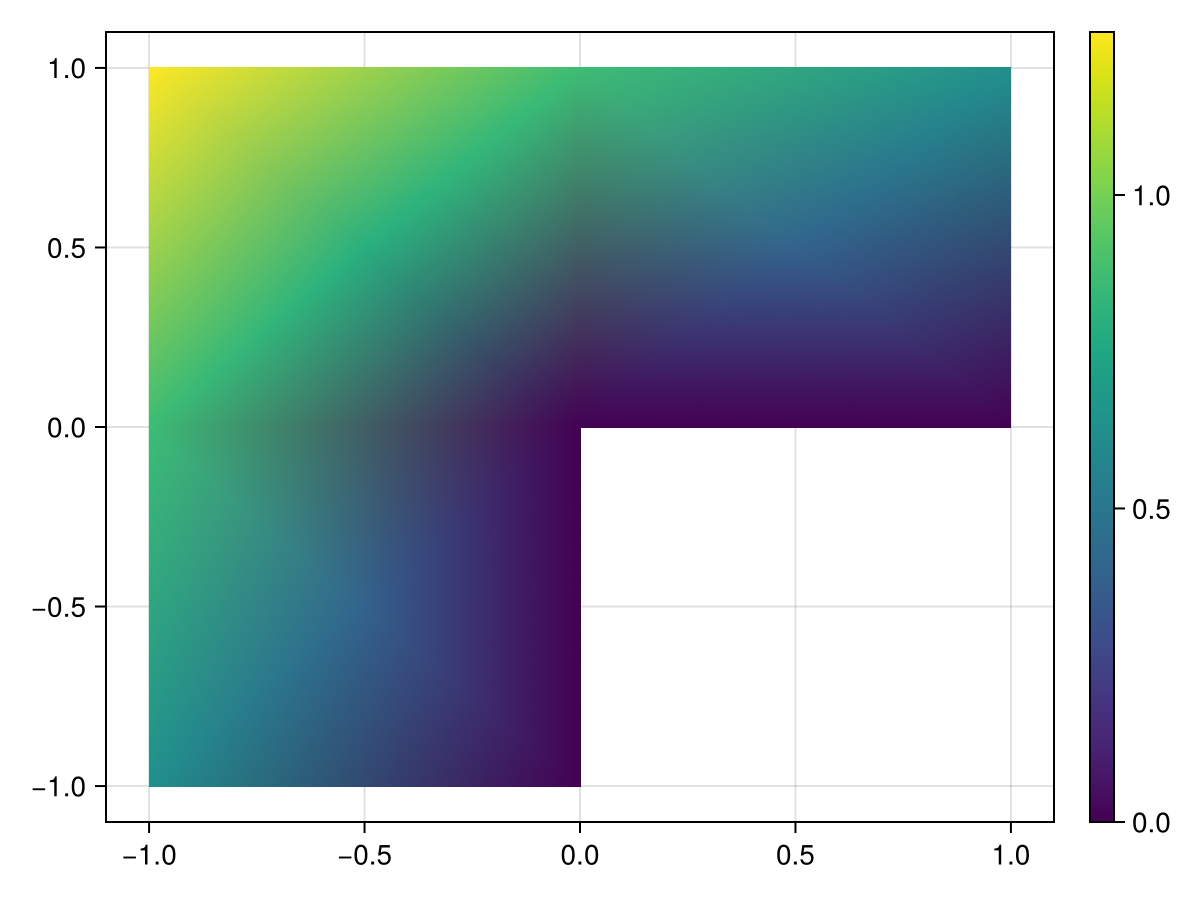

In [2]:
"Have to convert from -[π, π] to [0, 2π]"
function θ(x)
  θt = atan(x[2], x[1])
  (θt >= 0) * θt + (θt < 0) * (θt + 2 * π)
end

r(x) = sqrt(x[1]^2 + x[2]^2)

α = 2 / 3

u(x) = r(x)^α * sin(θ(x) * α)
u_fig, _ , plt = plot(Ω, u, colormap=:viridis)
Colorbar(u_fig[1,2], plt)
u_fig

In [3]:
using Gridap.Geometry
using Gridap.Adaptivity
using EquilibratedFlux

We define some helper functions for computing the L² norm in Gridap

In [4]:
L2_inner_product(f, g, dx) = ∫(f ⋅ g) * dx

L2_norm_squared(f, dx) = L2_inner_product(f, f, dx)

function L2_norm_squared(f, model, order)
  degree = 2 * order + 2
  Ω = Triangulation(model)
  dx = Measure(Ω, degree)
  L2_norm_squared(f, dx)
end

L2_norm_squared (generic function with 2 methods)

Next, we define the Dörfler marking[1]

In [5]:
function dorfler_marking(η_arr)
  if η_arr isa Gridap.Arrays.LazyArray
    η_arr = EquilibratedFlux.smart_collect(η_arr)
  end
  θ = 0.3 # Marking parameter
  η_tot = sum(η_arr)
  sorted_inds = sortperm(η_arr, rev = true)
  sorted = η_arr[sorted_inds]
  η_partial = 0.0
  i = 1
  while η_partial <= θ * η_tot
    η_partial += sorted[i]
    i += 1
  end
  sorted_inds[1:i]
end

dorfler_marking (generic function with 1 method)

As a small example, we show the result of calling
`dorfler_marking`

This step just corresponds almost exact to the contents of the [first
Gridap.jl
tutorial](https://gridap.github.io/Tutorials/dev/pages/t001_poisson/#Tutorial-1:-Poisson-equation-1).

In [6]:
function solve_laplace(model, order, g)
  Ω = Triangulation(model)
  degree = 2 * order + 2
  dx = Measure(Ω, degree)
  a(u, v) = ∫(∇(v) ⊙ ∇(u)) * dx
  b(v) = ∫(v * 0.0) * dx
  reffe = ReferenceFE(lagrangian, Float64, order)
  V0 = TestFESpace(model, reffe; conformity = :H1, dirichlet_tags = "boundary")
  U = TrialFESpace(V0, g)
  op = AffineFEOperator(a, b, U, V0)
  uh = solve(op)
  dofs = num_free_dofs(V0)
  uh, dx, dofs
end

solve_laplace (generic function with 1 method)

This function uses the EquilibratedFlux.jl package to obtain an error estimation on each
cell of the mesh.

In [7]:
function estimate_laplace(uh, dx, model, order)
    σ = build_equilibrated_flux(-∇(uh), x -> 0.0, model, order)
    #σ = build_averaged_flux(∇(uh), model)
    η² = L2_norm_squared(σ + ∇(uh), dx)
    Ω = Triangulation(model)
    getindex(η², Ω)
end

estimate_laplace (generic function with 1 method)

Finally, this function puts the previous functions together into the standard
Solve -> Estimate -> Mark -> Refine loop of AFEM. The refinement step using
newest vertex bisection can be selected using "nvb" with the keyword argument
refinement_method. $g$ is the function on the Dirichlet boundary.

In [8]:
function solve_estimate_mark_refine_laplace(model, tol, order; g)
    η = Inf
    estimators = Float64[]
    errors = Float64[]
    num_dofs = Float64[]
    error_fields = CellField[]
    while η > tol
        # We extract the internal model from the refined model
        if model isa AdaptedDiscreteModel
            model = model.model
        end
        # SOLVE
        uh, dx, dofs = solve_laplace(model, order, g)
        push!(num_dofs, dofs)
        # ESTIMATE
        η_arr = estimate_laplace(uh, dx, model, order)
        H1err² = L2_norm_squared(∇(u - uh), dx)
        Ω = Triangulation(model)
        error_field = CellField(sqrt.(getindex(H1err², Ω)), Ω)
        push!(error_fields, error_field)
        H1err = √sum(H1err²)
        η = √(sum(η_arr))
        push!(estimators, η)
        push!(errors, H1err)
        # MARK
        cells_to_refine = dorfler_marking(η_arr)
        # REFINE
        model = refine(model, refinement_method = "nvb", cells_to_refine = cells_to_refine)

    end
    return error_fields, num_dofs, estimators, errors
end

solve_estimate_mark_refine_laplace (generic function with 1 method)

We can change the polynomial order here as well as the tolerance for the
estimator.

In [9]:
order = 2
tol = 1e-4

0.0001

We pass the true solution as the Dirichlet function $g$

In [10]:
error_fields, num_dofs, estimators, errors = solve_estimate_mark_refine_laplace(model, tol, order, g = u);

We now show that the AFEM refinement achieves the optimal rate of convergence
of $\mathrm{DOFs}^{-p/d} = \mathrm{DOFs}^{-p/2}$ in 2D.

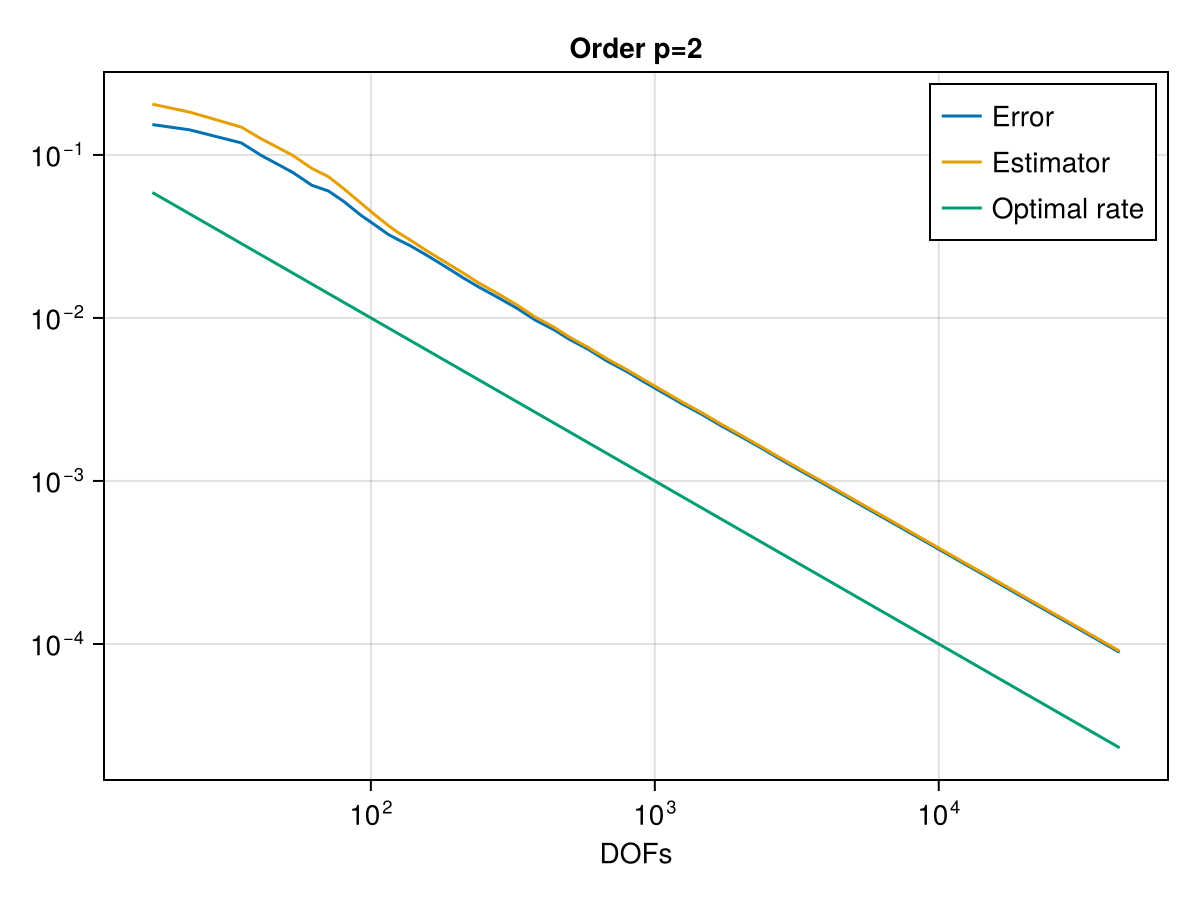

In [11]:
fig = Figure()
axis = Axis(fig[1,1], xscale = log10, yscale = log10, title = "Order p=$order", xlabel = "DOFs")
lines!(axis, num_dofs, errors, label = "Error")
lines!(axis, num_dofs, estimators, label = "Estimator")
lines!(axis, num_dofs, num_dofs.^(-order / 2), label = "Optimal rate")
axislegend()
fig

Finally, the following animation shows the sequence of meshes generated by the
adaptive refinement procedure. The refinement is clearly concentrated to the
re-entrant corner.

┌ Warning: `compression`, with value 0
│ was passed as a keyword argument to `record` or `VideoStream`,
│ which only has an effect when the output video's format is one of: ["mp4", "webm"].
│ But the actual video format was "gif".
│ Keyword arg `compression` will be ignored.
└ @ Makie ~/.julia/packages/Makie/Y3ABD/src/ffmpeg-util.jl:75


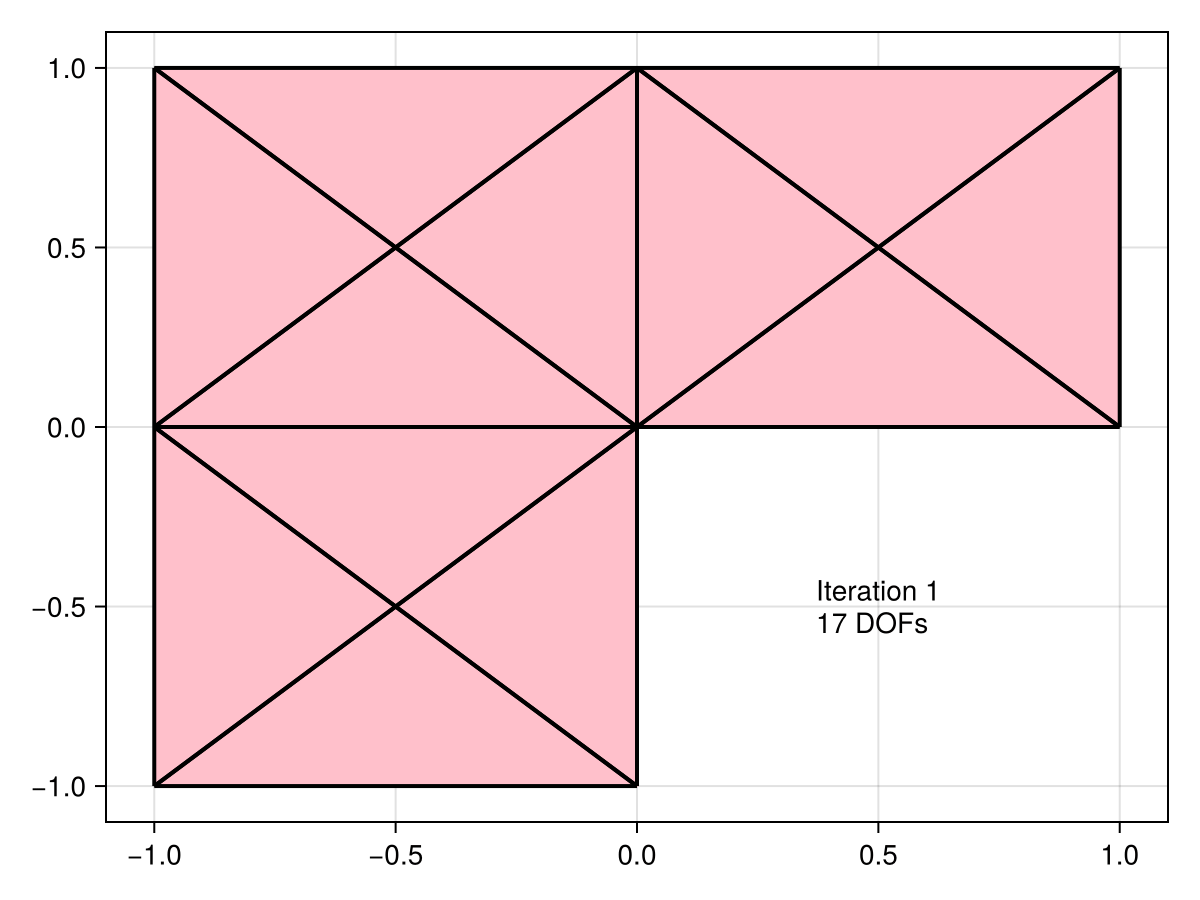

In [12]:
let
    idx = Observable(1)
    Ωᵢ = lift(idx) do i
        error_fields[i].trian
    end
    nDOFᵢ = lift(idx) do i
        "Iteration $i\n$(Int(num_dofs[i])) DOFs"
    end

    fig, ax, plt = plot(Ωᵢ)
    wireframe!(Ωᵢ, color=:black, linewidth=2)
    text!(ax, (0.5, -0.5), text=nDOFᵢ, align=(:center, :center), justification=:left)

    record(fig, "animation.gif", eachindex(error_fields); framerate=2, compression=0) do i
       idx[] = i
    end
    display(MIME"image/gif"(), read("animation.gif"))
end

[1] Dörfler, W. A convergent adaptive algorithm for Poisson’s equation. SIAM
Journal on Numerical Analysis 33, 3 (1996), 1106–1124

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*